# flutype-task

### Aim : To build a simple classification model, which allows to predict the virus type from given features P.

In [98]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline  
import pandas as pd
from itertools import cycle

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

### Both the training and test data is directly downloaded from github.

In [11]:

# Loading test data set 
url ="https://raw.githubusercontent.com/matthiaskoenig/flutype-task/master/data/flutype_test.csv"
dtest = pd.read_csv(url, sep="\t")

# Loading training data set 
url ="https://raw.githubusercontent.com/matthiaskoenig/flutype-task/master/data/flutype_train.csv"
dtrain = pd.read_csv(url, sep="\t")


### As both the training and test datasets are provided, train/test split method is not employed.
* Features and responses of both training  and test datasets are seperated.
* Features data of both training and test datasets are standardized to standard normally distributed data.
* Only few features are used for building the model.
   * Reasons: 
     * In order to build a realistic model. 
     * Using all the features lead to 100% accuracy and unrealistic model.
* Response/dependent variables are converted to int type from string.(for both train/test data)


In [97]:
# Seperating features and labels

X_train=dtrain.iloc[:,1: ]
X_test=dtest.iloc[:,1: ]


# Scale the data to be between -1 and 1

scaler = StandardScaler()
scaler.fit(X_train)
scaler.fit(X_test)

X_train= scaler.transform(X_train)
X_test= scaler.transform(X_test)

# only first six features are selected 

X_train = X_train[:, :6]
X_test = X_test[:, :6]

# Converting string value to int type for labels

y_train= dtrain.iloc[:,0]
y_test= dtest.iloc[:,0]

#Vl = virus labels

Vl = LabelEncoder()
y_train =Vl.fit_transform(y_train)
y_test = Vl.fit_transform(y_test)

# Encode labels 
# X31 --> 5 ;  Vi  --> 4 ; NY  --> 3 ; #H7  -->2 ; #H5  -->1 ; #H1  -->0

list(Vl.inverse_transform([5,4,3, 2, 1,0]))


['X31', 'Vi', 'NY', 'H7', 'H5', 'H1']

### classification algorithm : Loggistic regression (one vs rest)  
 * training score : 0.958333333333

In [93]:
# Training a logistic regression model on the training data set

Lg = LogisticRegression(multi_class="ovr",solver="lbfgs")
Lg.fit (X_train,y_train)

# Class prediction from the testing set

y_pred = Lg.predict(X_test)

#Classification accuracy 

print "Accuracy Score:",metrics.accuracy_score(y_test, y_pred)

# confusion matrix

confusion=metrics.confusion_matrix (y_test, y_pred) 
confusion

 Accuracy Score: 0.958333333333


array([[4, 0, 0, 0, 0, 0],
       [0, 4, 0, 0, 0, 0],
       [0, 0, 4, 0, 0, 0],
       [0, 0, 0, 4, 0, 0],
       [0, 0, 0, 1, 3, 0],
       [0, 0, 0, 0, 0, 4]])

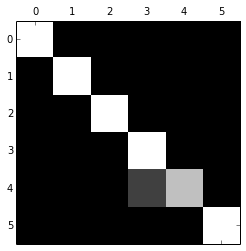

In [99]:
# confusion matrix heat map 

plt.matshow(confusion, cmap=plt.cm.gray)
plt.show()



In [100]:
# Classification report

print metrics.classification_report(y_test, y_pred) 

             precision    recall  f1-score   support

          0       1.00      1.00      1.00         4
          1       1.00      1.00      1.00         4
          2       1.00      1.00      1.00         4
          3       0.80      1.00      0.89         4
          4       1.00      0.75      0.86         4
          5       1.00      1.00      1.00         4

avg / total       0.97      0.96      0.96        24



### In order to extend binary classification algorithms to multi-class.
* Response of test data and the predicted response from the model are binarized.
* Generally binarizing the data is employed before training model but in this case i tired to do it later.
  And the plots generated by the binarized data seems to comply with the model generated. 

In [101]:
# Binarize for multi-class plots 

y_Test = label_binarize(y_test, classes=[0, 1, 2, 3, 4, 5])

n_classes = y_Test.shape[1]  # total number of classes 

y_Pred = label_binarize(y_pred, classes=[0, 1, 2, 3, 4, 5])

### Receiver operating characteristic (ROC)
* Codes for plotting Roc for multi-class are adapted from scikit-learn documenation 
  (http://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve)
* single ROC curve for each class are plotted in a single plot (one vs. rest) scheme.

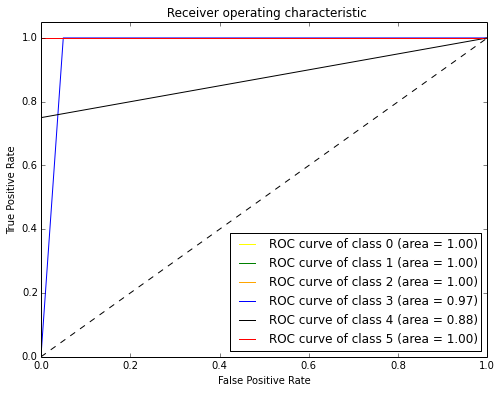

In [105]:
# Compute ROC curve and ROC area for each class

fpr = dict() # False Postive Rate
tpr = dict() # True Positive Rate
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_Test[:, i], y_Pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure()
lw = 1
colors = cycle(['yellow', 'green', 'orange', 'blue', 'black','red'])
                
plt.subplots(1, sharex='col', sharey='row', figsize=(8, 6))

for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(' Receiver operating characteristic ')
plt.legend(loc="best")
plt.show()


### Precision - Recall plot   
* Codes for plotting percision-recall for multi-class are adapted from scikit-learn documenation 
  (http://scikit-learn.org/stable/auto_examples/model_selection/plot_precision_recall.html#sphx-glr-auto-examples-model-selection-plot-precision-recall-py)
  
* "algorithms that optimize the area under the ROC curve are not guaranteed to optimize the area under the PR curve" (http://pages.cs.wisc.edu/~jdavis/davisgoadrichcamera2.pdf) so i generated both ROC and PR plots.

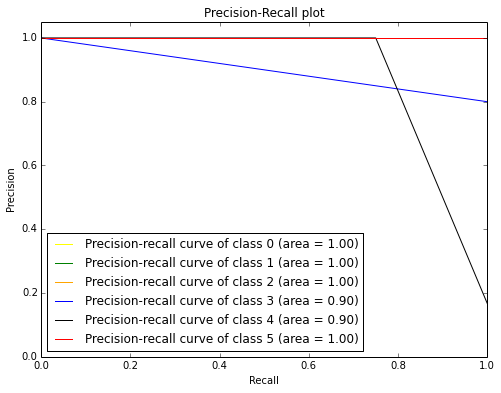

In [104]:
# Compute Precision-Recall and plot curve
precision = dict()
recall = dict()
average_precision = dict()
for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(y_Test[:, i],
                                                        y_Pred[:, i])
    average_precision[i] = average_precision_score(y_Test[:, i], y_Pred[:, i])

# Plotting details
colors = cycle(['yellow', 'green', 'orange', 'blue', 'black','red'])
lw = 1

plt.subplots(1, sharex='col', sharey='row', figsize=(8, 6))


# Plot Precision-Recall curve
for i, color in zip(range(n_classes), colors):
    plt.plot(recall[i], precision[i], color=color, lw=lw,
             label='Precision-recall curve of class {0} (area = {1:0.2f})'
                   ''.format(i, average_precision[i]))

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall plot')
plt.legend(loc="best")
plt.show()

### Additional info :
* As mentioned in the task, the simplest solution is Logistic regression, i find that other methods for this classification problem are equally trival in **"implementation"**. Thanks to the effective and significant simplification of machine learning in python using scikit-learn library with thorough and well-written documentation. 

* And i also find pre-processing of the data is really important as different methods have different criterions for fitting the model data. 

* Most of the implementations are restricted to the binary classification tasks.


